In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_35668/2809884579.py:45: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


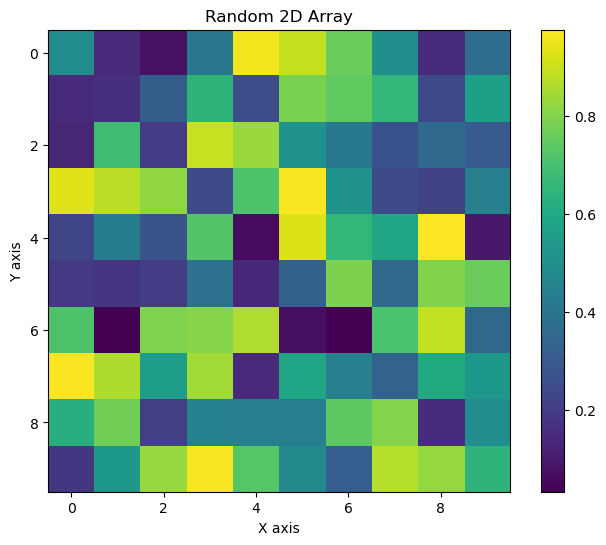

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
 # dvs 데이터 시각화 코드
 ##############################################################################################
            # mapping = {
            #     0: 'Hand Clapping',
            #     1: 'Right Hand Wave',
            #     2: 'Left Hand Wave',
            #     3: 'Right Arm CW',
            #     4: 'Right Arm CCW',
            #     5: 'Left Arm CW',
            #     6: 'Left Arm CCW',
            #     7: 'Arm Roll',
            #     8: 'Air Drums',
            #     9: 'Air Guitar',
            #     10: 'Other'
            # }
def dvs_visualization(inputs, labels, TIME, BATCH):
            
    what_input = random.randint(0, BATCH - 1)
    inputs_for_view = inputs.permute(1, 0, 2, 3, 4)
    for i in range(TIME):
        # 예시 데이터 생성
        data1 = inputs_for_view[what_input][i][0].numpy()  # torch tensor를 numpy 배열로 변환
        data2 = inputs_for_view[what_input][i][1].numpy()  # torch tensor를 numpy 배열로 변환

        # 데이터 플로팅
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # 1행 2열의 subplot 생성

        # 첫 번째 subplot에 데이터1 플로팅
        im1 = axs[0].imshow(data1, cmap='viridis', interpolation='nearest')
        axs[0].set_title(f'Channel 0\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[0].set_xlabel('X axis')
        axs[0].set_ylabel('Y axis')
        axs[0].grid(False)
        fig.colorbar(im1, ax=axs[0])  # Color bar 추가

        # 두 번째 subplot에 데이터2 플로팅
        im2 = axs[1].imshow(data2, cmap='viridis', interpolation='nearest')
        axs[1].set_title(f'Channel 1\nLabel: {labels[what_input]}  Time: {i}')  # 라벨값 맵핑하여 제목에 추가
        axs[1].set_xlabel('X axis')
        axs[1].set_ylabel('Y axis')
        axs[1].grid(False)
        fig.colorbar(im2, ax=axs[1])  # Color bar 추가

        plt.tight_layout()  # subplot 간 간격 조정
        plt.show()
    sys.exit("종료")

######################################################################################################

In [5]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = True, 
                    dvs_duration = 1000000,

                    OTTT_sWS_on = True, # True # False
                  ):
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and convTrue_fcFalse == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False

    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    wandb.config.update(hyperparameters)
    wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
    wandb.define_metric("summary_val_acc", summary="max")
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    torch.manual_seed(my_seed)
    ###################################################################################################################################


    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            # elif (in_channel == 'M'): #it's a holy FC layer!
            #     img_size = img_size // 2
            else:
                print('past_in_channel', past_in_channel)
                print('bias_param', bias_param)
                print('in_channel', in_channel)
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if pre_trained == False:
        if (convTrue_fcFalse == False):
            if (single_step == False):
                net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                            synapse_fc_trace_const1, synapse_fc_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on).to(device)
        else:
            if (single_step == False):
                net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
            else:
                net = MY_SNN_CONV_ottt_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                            synapse_conv_kernel_size, synapse_conv_stride, 
                            synapse_conv_padding, synapse_conv_trace_const1, 
                            synapse_conv_trace_const2, 
                            lif_layer_v_init, lif_layer_v_decay, 
                            lif_layer_v_threshold, lif_layer_v_reset,
                            lif_layer_sg_width,
                            synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                            tdBN_on,
                            BN_on, TIME,
                            surrogate,
                            BPTT_on,
                            OTTT_sWS_on).to(device)
        if (nda_net == True):
            net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                      lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
            net.T = TIME
        net = torch.nn.DataParallel(net) #나중에풀어줘
    else:
        net = torch.load(pre_trained_path)

    net = net.to(device)
    if (net_print == True):
        print(net)        
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
    if (weight_count_print == True):
        for name, param in net.named_parameters():
            if param.requires_grad:
                print(f'Layer: {name} | Number of parameters: {param.numel()}')
    # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
    # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
    print('='*50)
    print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
    memory = params_num / 8 / 1024 / 1024 # MB
    precision = 32
    memory = memory * precision 
    print(f"Memory: {memory:.2f}MiB at {precision}-bit")
    print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])
    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if (ddp_on == True):
            if torch.distributed.get_rank() == 0:   
                iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        else:
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(iterator)):
            validation_interval2 = len(iterator)
        ##################################################################################################



        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            # print('inputs',inputs.size(),'\nlabels',labels.size())
                    
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                

                
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH)
            # ######################################################################################################


            ## device로 보내주기 ######################################
            real_batch = labels.size(0)
            ###########################################################


            ## gradient 초기화 #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            ###########################################################


            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)

            

            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter_acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)

                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                loss = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += loss.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)


                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    # torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                    # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                    # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                    # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            iterator.set_description(f"iter_acc: {iter_acc_string}, iter_loss: {loss}, val_acc: {100 * val_acc_now:.2f}%")  
            wandb.log({"iter_acc": iter_acc}, step=i+epoch*len(train_loader))
            wandb.log({"tr_acc": tr_acc}, step=i+epoch*len(train_loader))
            wandb.log({"val_acc_now": val_acc_now}, step=i+epoch*len(train_loader))
            wandb.log({"summary_val_acc": val_acc_now})
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### 모듈 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # np.save(iter_acc_file_name_time, iter_acc_array)
            # np.save(tr_acc_file_name_time, iter_acc_array)
            # np.save(val_acc_file_name_time, val_acc_now_array)
            # with open(hyperparameters_file_name_time, 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## 모듈 세이브 ###########################################################################################
            # np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
            # np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
            # np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
            # with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
            #     json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [6]:
### my_snn control board ########################
decay = 0.5 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
wandb.init(project= f'my_snn {unique_name}')
my_snn_system(  devices = "2",
                single_step = True, # True # False
                unique_name = unique_name,
                my_seed = 42,
                TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 128, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'CIFAR10',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False

                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1,
                synapse_conv_trace_const2 = decay, # lif_layer_v_decay

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1,
                synapse_fc_trace_const2 = decay, # lif_layer_v_decay

                pre_trained = False, # True # False
                convTrue_fcFalse = True, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64],
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
                learning_rate = 0.1, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
                dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                #있는 데이터들 #gesture 1000000 #nmnist 10000

                OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


Files already downloaded and verified
Files already downloaded and verified
DataParallel(
  (module): MY_SNN_CONV_ottt_sstep(
    (layers): OTTTSequential(
      (0): SYNAPSE_CONV_trace_sstep()
      (1): LIF_layer_trace_sstep()
      (2): Scale()
      (3): SYNAPSE_CONV_trace_sstep()
      (4): LIF_layer_trace_sstep()
      (5): Scale()
      (6): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (7): SYNAPSE_CONV_trace_sstep()
      (8): LIF_layer_trace_sstep()
      (9): Scale()
      (10): SYNAPSE_CONV_trace_sstep()
      (11): LIF_layer_trace_sstep()
      (12): Scale()
      (13): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (14): SYNAPSE_CONV_trace_sstep()
      (15): LIF_layer_trace_sstep()
      (16): Scale()
      (17): SYNAPSE_CONV_trace_sstep()
      (18): LIF_layer_trace_sstep()
      (19): Scale()
      (20): AvgPool2d(kernel_size=2, stride=2, padding=0)
      (21): SYNAPSE_CONV_trace_sstep()
      (22): LIF_layer_trace_sstep()
      (23): Scale()
      (24): SYN

iter_acc: 0-0/391 iter_acc: 11.72%, lr=['0.1'], iter_loss: 2.1897177696228027, val_acc: 0.00%:   0%|          | 1/391 [00:01<07:40,  1.18s/it]

0.1171875


iter_acc: 0-10/391 iter_acc: 12.50%, lr=['0.1'], iter_loss: 2.196640968322754, val_acc: 0.00%:   3%|▎         | 11/391 [00:05<02:30,  2.52it/s]

0.125


iter_acc: 0-20/391 iter_acc: 10.94%, lr=['0.1'], iter_loss: 2.1795616149902344, val_acc: 0.00%:   5%|▌         | 21/391 [00:08<02:17,  2.70it/s]

0.109375


iter_acc: 0-30/391 iter_acc: 12.50%, lr=['0.1'], iter_loss: 2.1751058101654053, val_acc: 0.00%:   8%|▊         | 31/391 [00:12<02:26,  2.46it/s]

0.125


iter_acc: 0-40/391 iter_acc: 19.53%, lr=['0.1'], iter_loss: 2.0856008529663086, val_acc: 0.00%:  10%|█         | 41/391 [00:17<02:13,  2.62it/s]

0.1953125


iter_acc: 0-50/391 iter_acc: 21.09%, lr=['0.1'], iter_loss: 2.031451463699341, val_acc: 0.00%:  13%|█▎        | 51/391 [00:20<02:04,  2.73it/s] 

0.2109375


iter_acc: 0-60/391 iter_acc: 23.44%, lr=['0.1'], iter_loss: 1.9072198867797852, val_acc: 0.00%:  16%|█▌        | 61/391 [00:24<02:06,  2.61it/s]

0.234375


iter_acc: 0-70/391 iter_acc: 22.66%, lr=['0.1'], iter_loss: 1.971724271774292, val_acc: 0.00%:  18%|█▊        | 71/391 [00:29<02:13,  2.40it/s] 

0.2265625


iter_acc: 0-80/391 iter_acc: 21.88%, lr=['0.1'], iter_loss: 1.937985897064209, val_acc: 0.00%:  21%|██        | 81/391 [00:33<01:55,  2.68it/s] 

0.21875


iter_acc: 0-90/391 iter_acc: 24.22%, lr=['0.1'], iter_loss: 1.8941519260406494, val_acc: 0.00%:  23%|██▎       | 91/391 [00:36<01:51,  2.68it/s]

0.2421875


iter_acc: 0-100/391 iter_acc: 28.91%, lr=['0.1'], iter_loss: 1.8601794242858887, val_acc: 0.00%:  26%|██▌       | 101/391 [00:40<01:50,  2.62it/s]

0.2890625


iter_acc: 0-110/391 iter_acc: 28.12%, lr=['0.1'], iter_loss: 1.8220648765563965, val_acc: 0.00%:  28%|██▊       | 111/391 [00:44<01:49,  2.56it/s]

0.28125


iter_acc: 0-120/391 iter_acc: 32.81%, lr=['0.1'], iter_loss: 1.822894811630249, val_acc: 0.00%:  31%|███       | 121/391 [00:48<01:41,  2.67it/s] 

0.328125


iter_acc: 0-130/391 iter_acc: 25.00%, lr=['0.1'], iter_loss: 1.845144510269165, val_acc: 0.00%:  34%|███▎      | 131/391 [00:52<01:42,  2.53it/s] 

0.25


iter_acc: 0-140/391 iter_acc: 26.56%, lr=['0.1'], iter_loss: 1.7695602178573608, val_acc: 0.00%:  36%|███▌      | 141/391 [00:56<01:37,  2.55it/s]

0.265625


iter_acc: 0-150/391 iter_acc: 31.25%, lr=['0.1'], iter_loss: 1.723581314086914, val_acc: 0.00%:  39%|███▊      | 151/391 [01:00<01:28,  2.71it/s] 

0.3125


iter_acc: 0-160/391 iter_acc: 30.47%, lr=['0.1'], iter_loss: 1.6593009233474731, val_acc: 0.00%:  41%|████      | 161/391 [01:04<01:28,  2.61it/s]

0.3046875


iter_acc: 0-170/391 iter_acc: 35.94%, lr=['0.1'], iter_loss: 1.7545313835144043, val_acc: 0.00%:  44%|████▎     | 171/391 [01:08<01:22,  2.67it/s]

0.359375


iter_acc: 0-180/391 iter_acc: 36.72%, lr=['0.1'], iter_loss: 1.6405390501022339, val_acc: 0.00%:  46%|████▋     | 181/391 [01:11<01:17,  2.70it/s]

0.3671875


iter_acc: 0-190/391 iter_acc: 36.72%, lr=['0.1'], iter_loss: 1.7015174627304077, val_acc: 0.00%:  49%|████▉     | 191/391 [01:15<01:14,  2.70it/s]

0.3671875


iter_acc: 0-200/391 iter_acc: 44.53%, lr=['0.1'], iter_loss: 1.5349280834197998, val_acc: 0.00%:  51%|█████▏    | 201/391 [01:20<01:17,  2.46it/s]

0.4453125


iter_acc: 0-210/391 iter_acc: 42.19%, lr=['0.1'], iter_loss: 1.5948231220245361, val_acc: 0.00%:  54%|█████▍    | 211/391 [01:24<01:08,  2.64it/s]

0.421875


iter_acc: 0-220/391 iter_acc: 39.06%, lr=['0.1'], iter_loss: 1.6874350309371948, val_acc: 0.00%:  57%|█████▋    | 221/391 [01:28<01:02,  2.70it/s]

0.390625


iter_acc: 0-230/391 iter_acc: 39.06%, lr=['0.1'], iter_loss: 1.6067249774932861, val_acc: 0.00%:  59%|█████▉    | 231/391 [01:32<01:14,  2.16it/s]

0.390625


iter_acc: 0-240/391 iter_acc: 35.94%, lr=['0.1'], iter_loss: 1.7301197052001953, val_acc: 0.00%:  62%|██████▏   | 241/391 [01:36<00:56,  2.65it/s]

0.359375


iter_acc: 0-250/391 iter_acc: 42.19%, lr=['0.1'], iter_loss: 1.469311237335205, val_acc: 0.00%:  64%|██████▍   | 251/391 [01:40<00:55,  2.53it/s] 

0.421875


iter_acc: 0-260/391 iter_acc: 39.06%, lr=['0.1'], iter_loss: 1.589125394821167, val_acc: 0.00%:  67%|██████▋   | 261/391 [01:44<00:51,  2.50it/s] 

0.390625


iter_acc: 0-270/391 iter_acc: 30.47%, lr=['0.1'], iter_loss: 1.6584250926971436, val_acc: 0.00%:  69%|██████▉   | 271/391 [01:49<00:51,  2.32it/s]

0.3046875


iter_acc: 0-280/391 iter_acc: 39.84%, lr=['0.1'], iter_loss: 1.5150566101074219, val_acc: 0.00%:  72%|███████▏  | 281/391 [01:53<00:41,  2.63it/s]

0.3984375


iter_acc: 0-290/391 iter_acc: 41.41%, lr=['0.1'], iter_loss: 1.642518162727356, val_acc: 0.00%:  74%|███████▍  | 291/391 [01:57<00:38,  2.60it/s] 

0.4140625


iter_acc: 0-300/391 iter_acc: 31.25%, lr=['0.1'], iter_loss: 1.620697021484375, val_acc: 0.00%:  77%|███████▋  | 301/391 [02:02<00:37,  2.41it/s] 

0.3125


iter_acc: 0-310/391 iter_acc: 42.97%, lr=['0.1'], iter_loss: 1.532922387123108, val_acc: 0.00%:  80%|███████▉  | 311/391 [02:06<00:30,  2.64it/s] 

0.4296875


iter_acc: 0-320/391 iter_acc: 47.66%, lr=['0.1'], iter_loss: 1.455384373664856, val_acc: 0.00%:  82%|████████▏ | 321/391 [02:10<00:25,  2.70it/s] 

0.4765625


iter_acc: 0-330/391 iter_acc: 38.28%, lr=['0.1'], iter_loss: 1.676748514175415, val_acc: 0.00%:  85%|████████▍ | 331/391 [02:13<00:22,  2.71it/s] 

0.3828125


iter_acc: 0-340/391 iter_acc: 40.62%, lr=['0.1'], iter_loss: 1.6009624004364014, val_acc: 0.00%:  87%|████████▋ | 341/391 [02:17<00:19,  2.59it/s]

0.40625


iter_acc: 0-350/391 iter_acc: 50.78%, lr=['0.1'], iter_loss: 1.4546102285385132, val_acc: 0.00%:  90%|████████▉ | 351/391 [02:21<00:14,  2.70it/s]

0.5078125


iter_acc: 0-360/391 iter_acc: 41.41%, lr=['0.1'], iter_loss: 1.5961799621582031, val_acc: 0.00%:  92%|█████████▏| 361/391 [02:25<00:11,  2.66it/s]

0.4140625


iter_acc: 0-370/391 iter_acc: 53.91%, lr=['0.1'], iter_loss: 1.2970210313796997, val_acc: 0.00%:  95%|█████████▍| 371/391 [02:29<00:07,  2.53it/s]

0.5390625


iter_acc: 0-380/391 iter_acc: 48.44%, lr=['0.1'], iter_loss: 1.419586420059204, val_acc: 0.00%:  97%|█████████▋| 381/391 [02:33<00:03,  2.61it/s] 

0.484375


iter_acc: 0-389/391 iter_acc: 51.56%, lr=['0.1'], iter_loss: 1.4603748321533203, val_acc: 0.00%: 100%|█████████▉| 390/391 [02:36<00:00,  2.55it/s]

0.425


iter_acc: 0-390/391 iter_acc: 42.50%, lr=['0.1'], iter_loss: 0.220193013548851, val_acc: 52.06%: 100%|██████████| 391/391 [02:57<00:00,  2.20it/s]

epoch_time: 177.77717661857605 seconds

EPOCH 1



iter_acc: 1-0/391 iter_acc: 42.97%, lr=['0.09999725846827562'], iter_loss: 1.4844014644622803, val_acc: 52.06%:   0%|          | 1/391 [00:00<02:43,  2.39it/s]

0.4296875


iter_acc: 1-10/391 iter_acc: 53.12%, lr=['0.09999725846827562'], iter_loss: 1.403048038482666, val_acc: 52.06%:   3%|▎         | 11/391 [00:04<02:27,  2.58it/s]

0.53125


iter_acc: 1-20/391 iter_acc: 44.53%, lr=['0.09999725846827562'], iter_loss: 1.4832648038864136, val_acc: 52.06%:   5%|▌         | 21/391 [00:09<02:54,  2.12it/s]

0.4453125


iter_acc: 1-30/391 iter_acc: 55.47%, lr=['0.09999725846827562'], iter_loss: 1.4393479824066162, val_acc: 52.06%:   8%|▊         | 31/391 [00:13<02:20,  2.57it/s]

0.5546875


iter_acc: 1-40/391 iter_acc: 39.84%, lr=['0.09999725846827562'], iter_loss: 1.5450115203857422, val_acc: 52.06%:  10%|█         | 41/391 [00:17<02:11,  2.66it/s]

0.3984375


iter_acc: 1-50/391 iter_acc: 50.78%, lr=['0.09999725846827562'], iter_loss: 1.3955087661743164, val_acc: 52.06%:  13%|█▎        | 51/391 [00:21<02:09,  2.62it/s]

0.5078125


iter_acc: 1-60/391 iter_acc: 53.12%, lr=['0.09999725846827562'], iter_loss: 1.2884862422943115, val_acc: 52.06%:  16%|█▌        | 61/391 [00:25<02:11,  2.51it/s]

0.53125


iter_acc: 1-70/391 iter_acc: 52.34%, lr=['0.09999725846827562'], iter_loss: 1.4022064208984375, val_acc: 52.06%:  18%|█▊        | 71/391 [00:29<02:02,  2.61it/s]

0.5234375


iter_acc: 1-80/391 iter_acc: 49.22%, lr=['0.09999725846827562'], iter_loss: 1.4556443691253662, val_acc: 52.06%:  21%|██        | 81/391 [00:33<01:55,  2.69it/s]

0.4921875


iter_acc: 1-90/391 iter_acc: 48.44%, lr=['0.09999725846827562'], iter_loss: 1.4629511833190918, val_acc: 52.06%:  23%|██▎       | 91/391 [00:36<01:54,  2.63it/s]

0.484375


iter_acc: 1-100/391 iter_acc: 55.47%, lr=['0.09999725846827562'], iter_loss: 1.3882136344909668, val_acc: 52.06%:  26%|██▌       | 101/391 [00:40<01:49,  2.65it/s]

0.5546875


iter_acc: 1-110/391 iter_acc: 41.41%, lr=['0.09999725846827562'], iter_loss: 1.3585550785064697, val_acc: 52.06%:  28%|██▊       | 111/391 [00:44<01:50,  2.54it/s]

0.4140625


iter_acc: 1-120/391 iter_acc: 53.91%, lr=['0.09999725846827562'], iter_loss: 1.3276844024658203, val_acc: 52.06%:  31%|███       | 121/391 [00:49<01:52,  2.41it/s]

0.5390625


iter_acc: 1-130/391 iter_acc: 58.59%, lr=['0.09999725846827562'], iter_loss: 1.4044194221496582, val_acc: 52.06%:  34%|███▎      | 131/391 [00:54<01:41,  2.57it/s]

0.5859375


iter_acc: 1-140/391 iter_acc: 57.81%, lr=['0.09999725846827562'], iter_loss: 1.3625913858413696, val_acc: 52.06%:  36%|███▌      | 141/391 [00:57<01:37,  2.56it/s]

0.578125


iter_acc: 1-150/391 iter_acc: 49.22%, lr=['0.09999725846827562'], iter_loss: 1.4086624383926392, val_acc: 52.06%:  39%|███▊      | 151/391 [01:01<01:32,  2.59it/s]

0.4921875


iter_acc: 1-160/391 iter_acc: 42.97%, lr=['0.09999725846827562'], iter_loss: 1.4536871910095215, val_acc: 52.06%:  41%|████      | 161/391 [01:05<01:30,  2.54it/s]

0.4296875


iter_acc: 1-170/391 iter_acc: 54.69%, lr=['0.09999725846827562'], iter_loss: 1.3727422952651978, val_acc: 52.06%:  44%|████▎     | 171/391 [01:09<01:24,  2.61it/s]

0.546875


iter_acc: 1-180/391 iter_acc: 56.25%, lr=['0.09999725846827562'], iter_loss: 1.2100310325622559, val_acc: 52.06%:  46%|████▋     | 181/391 [01:13<01:21,  2.57it/s]

0.5625


iter_acc: 1-190/391 iter_acc: 57.03%, lr=['0.09999725846827562'], iter_loss: 1.2749890089035034, val_acc: 52.06%:  49%|████▉     | 191/391 [01:17<01:20,  2.49it/s]

0.5703125


iter_acc: 1-200/391 iter_acc: 55.47%, lr=['0.09999725846827562'], iter_loss: 1.140990138053894, val_acc: 52.06%:  51%|█████▏    | 201/391 [01:21<01:11,  2.64it/s] 

0.5546875


iter_acc: 1-210/391 iter_acc: 54.69%, lr=['0.09999725846827562'], iter_loss: 1.2327455282211304, val_acc: 52.06%:  54%|█████▍    | 211/391 [01:26<01:18,  2.30it/s]

0.546875


iter_acc: 1-220/391 iter_acc: 51.56%, lr=['0.09999725846827562'], iter_loss: 1.305238962173462, val_acc: 52.06%:  57%|█████▋    | 221/391 [01:30<01:11,  2.39it/s] 

0.515625


iter_acc: 1-230/391 iter_acc: 53.12%, lr=['0.09999725846827562'], iter_loss: 1.285125494003296, val_acc: 52.06%:  59%|█████▉    | 231/391 [01:34<01:04,  2.48it/s] 

0.53125


iter_acc: 1-240/391 iter_acc: 53.91%, lr=['0.09999725846827562'], iter_loss: 1.2580736875534058, val_acc: 52.06%:  62%|██████▏   | 241/391 [01:38<01:00,  2.47it/s]

0.5390625


iter_acc: 1-250/391 iter_acc: 57.03%, lr=['0.09999725846827562'], iter_loss: 1.30508291721344, val_acc: 52.06%:  64%|██████▍   | 251/391 [01:43<01:23,  1.69it/s]  

0.5703125


iter_acc: 1-260/391 iter_acc: 54.69%, lr=['0.09999725846827562'], iter_loss: 1.1397587060928345, val_acc: 52.06%:  67%|██████▋   | 261/391 [01:47<00:51,  2.50it/s]

0.546875


iter_acc: 1-270/391 iter_acc: 58.59%, lr=['0.09999725846827562'], iter_loss: 1.2436730861663818, val_acc: 52.06%:  69%|██████▉   | 271/391 [01:51<00:45,  2.64it/s]

0.5859375


iter_acc: 1-280/391 iter_acc: 46.88%, lr=['0.09999725846827562'], iter_loss: 1.4787213802337646, val_acc: 52.06%:  72%|███████▏  | 281/391 [01:55<00:41,  2.64it/s]

0.46875


iter_acc: 1-290/391 iter_acc: 55.47%, lr=['0.09999725846827562'], iter_loss: 1.2418959140777588, val_acc: 52.06%:  74%|███████▍  | 291/391 [01:59<00:38,  2.60it/s]

0.5546875


iter_acc: 1-300/391 iter_acc: 54.69%, lr=['0.09999725846827562'], iter_loss: 1.3166749477386475, val_acc: 52.06%:  77%|███████▋  | 301/391 [02:03<00:35,  2.50it/s]

0.546875


iter_acc: 1-310/391 iter_acc: 57.03%, lr=['0.09999725846827562'], iter_loss: 1.2840076684951782, val_acc: 52.06%:  80%|███████▉  | 311/391 [02:07<00:31,  2.52it/s]

0.5703125


iter_acc: 1-320/391 iter_acc: 58.59%, lr=['0.09999725846827562'], iter_loss: 1.1896201372146606, val_acc: 52.06%:  82%|████████▏ | 321/391 [02:11<00:29,  2.41it/s]

0.5859375


iter_acc: 1-330/391 iter_acc: 53.91%, lr=['0.09999725846827562'], iter_loss: 1.2572981119155884, val_acc: 52.06%:  85%|████████▍ | 331/391 [02:15<00:22,  2.61it/s]

0.5390625


iter_acc: 1-340/391 iter_acc: 60.16%, lr=['0.09999725846827562'], iter_loss: 1.137863278388977, val_acc: 52.06%:  87%|████████▋ | 341/391 [02:20<00:20,  2.47it/s] 

0.6015625


iter_acc: 1-350/391 iter_acc: 57.81%, lr=['0.09999725846827562'], iter_loss: 1.210634469985962, val_acc: 52.06%:  90%|████████▉ | 351/391 [02:25<00:17,  2.32it/s] 

0.578125


iter_acc: 1-360/391 iter_acc: 60.94%, lr=['0.09999725846827562'], iter_loss: 1.1937758922576904, val_acc: 52.06%:  92%|█████████▏| 361/391 [02:28<00:11,  2.63it/s]

0.609375


iter_acc: 1-370/391 iter_acc: 62.50%, lr=['0.09999725846827562'], iter_loss: 1.102381706237793, val_acc: 52.06%:  95%|█████████▍| 371/391 [02:32<00:07,  2.64it/s] 

0.625


iter_acc: 1-380/391 iter_acc: 61.72%, lr=['0.09999725846827562'], iter_loss: 1.0602134466171265, val_acc: 52.06%:  97%|█████████▋| 381/391 [02:36<00:03,  2.63it/s]

0.6171875


iter_acc: 1-389/391 iter_acc: 57.03%, lr=['0.09999725846827562'], iter_loss: 1.2911427021026611, val_acc: 52.06%: 100%|█████████▉| 390/391 [02:40<00:00,  2.50it/s]

0.5125


iter_acc: 1-390/391 iter_acc: 51.25%, lr=['0.09999725846827562'], iter_loss: 0.16959747672080994, val_acc: 63.07%: 100%|██████████| 391/391 [02:58<00:00,  2.19it/s]

epoch_time: 178.4301266670227 seconds

EPOCH 2



iter_acc: 2-0/391 iter_acc: 52.34%, lr=['0.09998903417374229'], iter_loss: 1.259758472442627, val_acc: 63.07%:   0%|          | 1/391 [00:00<02:31,  2.57it/s]

0.5234375


iter_acc: 2-10/391 iter_acc: 65.62%, lr=['0.09998903417374229'], iter_loss: 1.0999952554702759, val_acc: 63.07%:   3%|▎         | 11/391 [00:04<02:31,  2.51it/s]

0.65625


iter_acc: 2-20/391 iter_acc: 57.81%, lr=['0.09998903417374229'], iter_loss: 1.1990221738815308, val_acc: 63.07%:   5%|▌         | 21/391 [00:09<02:28,  2.50it/s]

0.578125


iter_acc: 2-30/391 iter_acc: 52.34%, lr=['0.09998903417374229'], iter_loss: 1.2352794408798218, val_acc: 63.07%:   8%|▊         | 31/391 [00:12<02:15,  2.65it/s]

0.5234375


iter_acc: 2-40/391 iter_acc: 60.94%, lr=['0.09998903417374229'], iter_loss: 1.0873582363128662, val_acc: 63.07%:  10%|█         | 41/391 [00:16<02:17,  2.54it/s]

0.609375


iter_acc: 2-50/391 iter_acc: 65.62%, lr=['0.09998903417374229'], iter_loss: 1.1166532039642334, val_acc: 63.07%:  13%|█▎        | 51/391 [00:22<02:24,  2.35it/s]

0.65625


iter_acc: 2-60/391 iter_acc: 60.94%, lr=['0.09998903417374229'], iter_loss: 1.1776552200317383, val_acc: 63.07%:  16%|█▌        | 61/391 [00:26<02:11,  2.51it/s]

0.609375


iter_acc: 2-70/391 iter_acc: 50.78%, lr=['0.09998903417374229'], iter_loss: 1.3218410015106201, val_acc: 63.07%:  18%|█▊        | 71/391 [00:30<02:08,  2.50it/s]

0.5078125


iter_acc: 2-80/391 iter_acc: 61.72%, lr=['0.09998903417374229'], iter_loss: 1.1691782474517822, val_acc: 63.07%:  21%|██        | 81/391 [00:34<01:59,  2.59it/s]

0.6171875


iter_acc: 2-90/391 iter_acc: 56.25%, lr=['0.09998903417374229'], iter_loss: 1.2672598361968994, val_acc: 63.07%:  23%|██▎       | 91/391 [00:40<03:55,  1.28it/s]

0.5625


iter_acc: 2-100/391 iter_acc: 60.16%, lr=['0.09998903417374229'], iter_loss: 1.2348997592926025, val_acc: 63.07%:  26%|██▌       | 101/391 [00:44<01:53,  2.56it/s]

0.6015625


iter_acc: 2-110/391 iter_acc: 50.00%, lr=['0.09998903417374229'], iter_loss: 1.333737850189209, val_acc: 63.07%:  28%|██▊       | 111/391 [00:48<01:45,  2.66it/s] 

0.5


iter_acc: 2-120/391 iter_acc: 61.72%, lr=['0.09998903417374229'], iter_loss: 1.1108853816986084, val_acc: 63.07%:  31%|███       | 121/391 [00:52<01:50,  2.45it/s]

0.6171875


iter_acc: 2-130/391 iter_acc: 60.94%, lr=['0.09998903417374229'], iter_loss: 1.176263689994812, val_acc: 63.07%:  34%|███▎      | 131/391 [00:56<01:43,  2.52it/s] 

0.609375


iter_acc: 2-140/391 iter_acc: 66.41%, lr=['0.09998903417374229'], iter_loss: 1.0738214254379272, val_acc: 63.07%:  36%|███▌      | 141/391 [01:00<01:34,  2.64it/s]

0.6640625


iter_acc: 2-150/391 iter_acc: 67.97%, lr=['0.09998903417374229'], iter_loss: 1.11995267868042, val_acc: 63.07%:  39%|███▊      | 151/391 [01:04<01:38,  2.44it/s]  

0.6796875


iter_acc: 2-160/391 iter_acc: 59.38%, lr=['0.09998903417374229'], iter_loss: 1.1530147790908813, val_acc: 63.07%:  41%|████      | 161/391 [01:08<01:25,  2.70it/s]

0.59375


iter_acc: 2-170/391 iter_acc: 59.38%, lr=['0.09998903417374229'], iter_loss: 1.1627490520477295, val_acc: 63.07%:  44%|████▎     | 171/391 [01:12<01:27,  2.52it/s]

0.59375


iter_acc: 2-180/391 iter_acc: 58.59%, lr=['0.09998903417374229'], iter_loss: 1.1276488304138184, val_acc: 63.07%:  46%|████▋     | 181/391 [01:17<01:20,  2.61it/s]

0.5859375


iter_acc: 2-190/391 iter_acc: 55.47%, lr=['0.09998903417374229'], iter_loss: 1.283094882965088, val_acc: 63.07%:  49%|████▉     | 191/391 [01:21<01:19,  2.53it/s] 

0.5546875


iter_acc: 2-200/391 iter_acc: 64.84%, lr=['0.09998903417374229'], iter_loss: 1.066792368888855, val_acc: 63.07%:  51%|█████▏    | 201/391 [01:26<01:39,  1.91it/s] 

0.6484375


iter_acc: 2-210/391 iter_acc: 60.94%, lr=['0.09998903417374229'], iter_loss: 1.148625135421753, val_acc: 63.07%:  54%|█████▍    | 211/391 [01:32<01:38,  1.82it/s] 

0.609375


iter_acc: 2-220/391 iter_acc: 64.06%, lr=['0.09998903417374229'], iter_loss: 1.0632219314575195, val_acc: 63.07%:  57%|█████▋    | 221/391 [01:36<01:06,  2.56it/s]

0.640625


iter_acc: 2-230/391 iter_acc: 62.50%, lr=['0.09998903417374229'], iter_loss: 1.1638598442077637, val_acc: 63.07%:  59%|█████▉    | 231/391 [01:40<00:59,  2.68it/s]

0.625


iter_acc: 2-240/391 iter_acc: 53.12%, lr=['0.09998903417374229'], iter_loss: 1.2846168279647827, val_acc: 63.07%:  62%|██████▏   | 241/391 [01:44<00:59,  2.50it/s]

0.53125


iter_acc: 2-250/391 iter_acc: 56.25%, lr=['0.09998903417374229'], iter_loss: 1.2125595808029175, val_acc: 63.07%:  64%|██████▍   | 251/391 [01:48<00:55,  2.52it/s]

0.5625


iter_acc: 2-260/391 iter_acc: 55.47%, lr=['0.09998903417374229'], iter_loss: 1.1887726783752441, val_acc: 63.07%:  67%|██████▋   | 261/391 [01:53<00:57,  2.26it/s]

0.5546875


iter_acc: 2-270/391 iter_acc: 67.97%, lr=['0.09998903417374229'], iter_loss: 0.995171844959259, val_acc: 63.07%:  69%|██████▉   | 271/391 [01:57<00:46,  2.59it/s] 

0.6796875


iter_acc: 2-280/391 iter_acc: 62.50%, lr=['0.09998903417374229'], iter_loss: 1.095526099205017, val_acc: 63.07%:  72%|███████▏  | 281/391 [02:01<00:44,  2.47it/s] 

0.625


iter_acc: 2-290/391 iter_acc: 64.06%, lr=['0.09998903417374229'], iter_loss: 1.0839650630950928, val_acc: 63.07%:  74%|███████▍  | 291/391 [02:05<00:37,  2.65it/s]

0.640625


iter_acc: 2-300/391 iter_acc: 69.53%, lr=['0.09998903417374229'], iter_loss: 1.0744001865386963, val_acc: 63.07%:  77%|███████▋  | 301/391 [02:09<00:33,  2.66it/s]

0.6953125


iter_acc: 2-310/391 iter_acc: 63.28%, lr=['0.09998903417374229'], iter_loss: 1.0559026002883911, val_acc: 63.07%:  80%|███████▉  | 311/391 [02:13<00:35,  2.28it/s]

0.6328125


iter_acc: 2-320/391 iter_acc: 64.06%, lr=['0.09998903417374229'], iter_loss: 1.1034866571426392, val_acc: 63.07%:  82%|████████▏ | 321/391 [02:17<00:28,  2.48it/s]

0.640625


iter_acc: 2-330/391 iter_acc: 67.19%, lr=['0.09998903417374229'], iter_loss: 0.9695225358009338, val_acc: 63.07%:  85%|████████▍ | 331/391 [02:21<00:23,  2.60it/s]

0.671875


iter_acc: 2-340/391 iter_acc: 68.75%, lr=['0.09998903417374229'], iter_loss: 1.0097699165344238, val_acc: 63.07%:  87%|████████▋ | 341/391 [02:25<00:21,  2.30it/s]

0.6875


iter_acc: 2-350/391 iter_acc: 70.31%, lr=['0.09998903417374229'], iter_loss: 1.0345796346664429, val_acc: 63.07%:  90%|████████▉ | 351/391 [02:29<00:15,  2.61it/s]

0.703125


iter_acc: 2-360/391 iter_acc: 61.72%, lr=['0.09998903417374229'], iter_loss: 1.16530442237854, val_acc: 63.07%:  92%|█████████▏| 361/391 [02:34<00:12,  2.37it/s]  

0.6171875


iter_acc: 2-370/391 iter_acc: 63.28%, lr=['0.09998903417374229'], iter_loss: 1.0808219909667969, val_acc: 63.07%:  95%|█████████▍| 371/391 [02:39<00:08,  2.31it/s]

0.6328125


iter_acc: 2-380/391 iter_acc: 61.72%, lr=['0.09998903417374229'], iter_loss: 1.1028881072998047, val_acc: 63.07%:  97%|█████████▋| 381/391 [02:44<00:04,  2.49it/s]

0.6171875


iter_acc: 2-389/391 iter_acc: 72.66%, lr=['0.09998903417374229'], iter_loss: 1.0611579418182373, val_acc: 63.07%: 100%|█████████▉| 390/391 [02:49<00:00,  1.42it/s]

0.5625


iter_acc: 2-390/391 iter_acc: 56.25%, lr=['0.09998903417374229'], iter_loss: 0.13838112354278564, val_acc: 69.26%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.89742946624756 seconds

EPOCH 3



iter_acc: 3-0/391 iter_acc: 66.41%, lr=['0.0999753280182866'], iter_loss: 0.9416620135307312, val_acc: 69.26%:   0%|          | 1/391 [00:00<02:44,  2.38it/s]

0.6640625


iter_acc: 3-10/391 iter_acc: 69.53%, lr=['0.0999753280182866'], iter_loss: 0.9350513815879822, val_acc: 69.26%:   3%|▎         | 11/391 [00:04<02:26,  2.59it/s]

0.6953125


iter_acc: 3-20/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.1948983669281006, val_acc: 69.26%:   5%|▌         | 21/391 [00:09<02:27,  2.51it/s]

0.6484375


iter_acc: 3-30/391 iter_acc: 63.28%, lr=['0.0999753280182866'], iter_loss: 1.1057802438735962, val_acc: 69.26%:   8%|▊         | 31/391 [00:13<02:18,  2.60it/s]

0.6328125


iter_acc: 3-40/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.067117691040039, val_acc: 69.26%:  10%|█         | 41/391 [00:17<02:13,  2.63it/s] 

0.6484375


iter_acc: 3-50/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.0434707403182983, val_acc: 69.26%:  13%|█▎        | 51/391 [00:20<02:09,  2.62it/s]

0.6484375


iter_acc: 3-60/391 iter_acc: 64.06%, lr=['0.0999753280182866'], iter_loss: 1.0548486709594727, val_acc: 69.26%:  16%|█▌        | 61/391 [00:24<02:03,  2.67it/s]

0.640625


iter_acc: 3-70/391 iter_acc: 65.62%, lr=['0.0999753280182866'], iter_loss: 0.9812283515930176, val_acc: 69.26%:  18%|█▊        | 71/391 [00:28<02:06,  2.54it/s]

0.65625


iter_acc: 3-80/391 iter_acc: 60.94%, lr=['0.0999753280182866'], iter_loss: 1.1133246421813965, val_acc: 69.26%:  21%|██        | 81/391 [00:33<02:34,  2.00it/s]

0.609375


iter_acc: 3-90/391 iter_acc: 61.72%, lr=['0.0999753280182866'], iter_loss: 1.1209241151809692, val_acc: 69.26%:  23%|██▎       | 91/391 [00:38<02:56,  1.70it/s]

0.6171875


iter_acc: 3-100/391 iter_acc: 65.62%, lr=['0.0999753280182866'], iter_loss: 1.0483063459396362, val_acc: 69.26%:  26%|██▌       | 101/391 [00:42<01:59,  2.43it/s]

0.65625


iter_acc: 3-110/391 iter_acc: 68.75%, lr=['0.0999753280182866'], iter_loss: 0.9342044591903687, val_acc: 69.26%:  28%|██▊       | 111/391 [00:46<01:45,  2.66it/s]

0.6875


iter_acc: 3-120/391 iter_acc: 61.72%, lr=['0.0999753280182866'], iter_loss: 1.1165357828140259, val_acc: 69.26%:  31%|███       | 121/391 [00:50<01:43,  2.62it/s]

0.6171875


iter_acc: 3-130/391 iter_acc: 72.66%, lr=['0.0999753280182866'], iter_loss: 0.9076790809631348, val_acc: 69.26%:  34%|███▎      | 131/391 [00:56<03:02,  1.43it/s]

0.7265625


iter_acc: 3-140/391 iter_acc: 70.31%, lr=['0.0999753280182866'], iter_loss: 0.9192605018615723, val_acc: 69.26%:  36%|███▌      | 141/391 [01:00<01:39,  2.51it/s]

0.703125


iter_acc: 3-150/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.1004817485809326, val_acc: 69.26%:  39%|███▊      | 151/391 [01:05<01:38,  2.43it/s]

0.6484375


iter_acc: 3-160/391 iter_acc: 59.38%, lr=['0.0999753280182866'], iter_loss: 1.098219633102417, val_acc: 69.26%:  41%|████      | 161/391 [01:10<01:56,  1.97it/s] 

0.59375


iter_acc: 3-170/391 iter_acc: 67.97%, lr=['0.0999753280182866'], iter_loss: 0.9810896515846252, val_acc: 69.26%:  44%|████▎     | 171/391 [01:16<01:38,  2.24it/s]

0.6796875


iter_acc: 3-180/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.1093965768814087, val_acc: 69.26%:  46%|████▋     | 181/391 [01:20<01:24,  2.50it/s]

0.6484375


iter_acc: 3-190/391 iter_acc: 67.97%, lr=['0.0999753280182866'], iter_loss: 0.9647483229637146, val_acc: 69.26%:  49%|████▉     | 191/391 [01:24<01:15,  2.63it/s]

0.6796875


iter_acc: 3-200/391 iter_acc: 63.28%, lr=['0.0999753280182866'], iter_loss: 1.1052907705307007, val_acc: 69.26%:  51%|█████▏    | 201/391 [01:28<01:14,  2.54it/s]

0.6328125


iter_acc: 3-210/391 iter_acc: 60.16%, lr=['0.0999753280182866'], iter_loss: 1.1483299732208252, val_acc: 69.26%:  54%|█████▍    | 211/391 [01:32<01:09,  2.61it/s]

0.6015625


iter_acc: 3-220/391 iter_acc: 64.06%, lr=['0.0999753280182866'], iter_loss: 1.0055230855941772, val_acc: 69.26%:  57%|█████▋    | 221/391 [01:35<01:06,  2.57it/s]

0.640625


iter_acc: 3-230/391 iter_acc: 67.97%, lr=['0.0999753280182866'], iter_loss: 0.9843496084213257, val_acc: 69.26%:  59%|█████▉    | 231/391 [01:41<01:48,  1.48it/s]

0.6796875


iter_acc: 3-240/391 iter_acc: 72.66%, lr=['0.0999753280182866'], iter_loss: 0.9015178680419922, val_acc: 69.26%:  62%|██████▏   | 241/391 [01:45<01:04,  2.34it/s]

0.7265625


iter_acc: 3-250/391 iter_acc: 64.06%, lr=['0.0999753280182866'], iter_loss: 1.028914213180542, val_acc: 69.26%:  64%|██████▍   | 251/391 [01:50<00:54,  2.59it/s] 

0.640625


iter_acc: 3-260/391 iter_acc: 61.72%, lr=['0.0999753280182866'], iter_loss: 1.046525478363037, val_acc: 69.26%:  67%|██████▋   | 261/391 [01:54<00:48,  2.69it/s] 

0.6171875


iter_acc: 3-270/391 iter_acc: 62.50%, lr=['0.0999753280182866'], iter_loss: 1.0828149318695068, val_acc: 69.26%:  69%|██████▉   | 271/391 [01:58<00:51,  2.35it/s]

0.625


iter_acc: 3-280/391 iter_acc: 60.16%, lr=['0.0999753280182866'], iter_loss: 1.0633172988891602, val_acc: 69.26%:  72%|███████▏  | 281/391 [02:02<00:41,  2.64it/s]

0.6015625


iter_acc: 3-290/391 iter_acc: 64.84%, lr=['0.0999753280182866'], iter_loss: 1.0399634838104248, val_acc: 69.26%:  74%|███████▍  | 291/391 [02:06<00:42,  2.34it/s]

0.6484375


iter_acc: 3-300/391 iter_acc: 65.62%, lr=['0.0999753280182866'], iter_loss: 1.032879114151001, val_acc: 69.26%:  77%|███████▋  | 301/391 [02:10<00:34,  2.59it/s] 

0.65625


iter_acc: 3-310/391 iter_acc: 70.31%, lr=['0.0999753280182866'], iter_loss: 0.8701926469802856, val_acc: 69.26%:  80%|███████▉  | 311/391 [02:14<00:30,  2.63it/s]

0.703125


iter_acc: 3-320/391 iter_acc: 66.41%, lr=['0.0999753280182866'], iter_loss: 1.0740208625793457, val_acc: 69.26%:  82%|████████▏ | 321/391 [02:18<00:26,  2.65it/s]

0.6640625


iter_acc: 3-330/391 iter_acc: 69.53%, lr=['0.0999753280182866'], iter_loss: 0.9181245565414429, val_acc: 69.26%:  85%|████████▍ | 331/391 [02:22<00:22,  2.65it/s]

0.6953125


iter_acc: 3-340/391 iter_acc: 60.94%, lr=['0.0999753280182866'], iter_loss: 1.0602360963821411, val_acc: 69.26%:  87%|████████▋ | 341/391 [02:28<00:26,  1.88it/s]

0.609375


iter_acc: 3-350/391 iter_acc: 65.62%, lr=['0.0999753280182866'], iter_loss: 1.1089916229248047, val_acc: 69.26%:  90%|████████▉ | 351/391 [02:32<00:15,  2.60it/s]

0.65625


iter_acc: 3-360/391 iter_acc: 70.31%, lr=['0.0999753280182866'], iter_loss: 0.9683647751808167, val_acc: 69.26%:  92%|█████████▏| 361/391 [02:37<00:13,  2.27it/s]

0.703125


iter_acc: 3-370/391 iter_acc: 68.75%, lr=['0.0999753280182866'], iter_loss: 0.9411826729774475, val_acc: 69.26%:  95%|█████████▍| 371/391 [02:42<00:07,  2.56it/s]

0.6875


iter_acc: 3-380/391 iter_acc: 67.97%, lr=['0.0999753280182866'], iter_loss: 1.0259621143341064, val_acc: 69.26%:  97%|█████████▋| 381/391 [02:46<00:03,  2.65it/s]

0.6796875


iter_acc: 3-389/391 iter_acc: 61.72%, lr=['0.0999753280182866'], iter_loss: 1.1243417263031006, val_acc: 69.26%: 100%|█████████▉| 390/391 [02:50<00:00,  2.60it/s]

0.6625


iter_acc: 3-390/391 iter_acc: 66.25%, lr=['0.0999753280182866'], iter_loss: 0.11543139070272446, val_acc: 73.27%: 100%|██████████| 391/391 [03:09<00:00,  2.06it/s]

epoch_time: 189.54013466835022 seconds

EPOCH 4



iter_acc: 4-0/391 iter_acc: 73.44%, lr=['0.09995614150494293'], iter_loss: 0.8873854279518127, val_acc: 73.27%:   0%|          | 1/391 [00:00<02:44,  2.37it/s]

0.734375


iter_acc: 4-10/391 iter_acc: 70.31%, lr=['0.09995614150494293'], iter_loss: 0.924592912197113, val_acc: 73.27%:   3%|▎         | 11/391 [00:04<02:30,  2.53it/s]

0.703125


iter_acc: 4-20/391 iter_acc: 70.31%, lr=['0.09995614150494293'], iter_loss: 0.9446913003921509, val_acc: 73.27%:   5%|▌         | 21/391 [00:08<02:24,  2.56it/s]

0.703125


iter_acc: 4-30/391 iter_acc: 66.41%, lr=['0.09995614150494293'], iter_loss: 1.064887285232544, val_acc: 73.27%:   8%|▊         | 31/391 [00:12<02:28,  2.43it/s] 

0.6640625


iter_acc: 4-40/391 iter_acc: 66.41%, lr=['0.09995614150494293'], iter_loss: 0.9694122076034546, val_acc: 73.27%:  10%|█         | 41/391 [00:16<02:16,  2.57it/s]

0.6640625


iter_acc: 4-50/391 iter_acc: 63.28%, lr=['0.09995614150494293'], iter_loss: 1.01361083984375, val_acc: 73.27%:  13%|█▎        | 51/391 [00:20<02:12,  2.57it/s]  

0.6328125


iter_acc: 4-60/391 iter_acc: 73.44%, lr=['0.09995614150494293'], iter_loss: 0.9134587645530701, val_acc: 73.27%:  16%|█▌        | 61/391 [00:24<02:07,  2.58it/s]

0.734375


iter_acc: 4-70/391 iter_acc: 70.31%, lr=['0.09995614150494293'], iter_loss: 0.9313748478889465, val_acc: 73.27%:  18%|█▊        | 71/391 [00:28<02:07,  2.50it/s]

0.703125


iter_acc: 4-80/391 iter_acc: 74.22%, lr=['0.09995614150494293'], iter_loss: 0.8400238156318665, val_acc: 73.27%:  21%|██        | 81/391 [00:32<02:01,  2.55it/s]

0.7421875


iter_acc: 4-89/391 iter_acc: 71.09%, lr=['0.09995614150494293'], iter_loss: 0.9300594925880432, val_acc: 73.27%:  23%|██▎       | 90/391 [00:35<02:02,  2.45it/s]

In [ ]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# unique_name_hyper = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"values": [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.0]},
#         "batch_size": {"values": [64, 96, 128]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init()
#     learning_rate  =  wandb.config.learning_rate
#     batch_size  =  wandb.config.batch_size
#     decay  =  wandb.config.decay

#     my_snn_system(  devices = "3",
#                     single_step = True, # True # False
#                     unique_name = unique_name,
#                     my_seed = 42,
#                     TIME = 6 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                     BATCH = batch_size, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                     IMAGE_SIZE = 32, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28
#                     # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                     #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                     # DVS_CIFAR10 할거면 time 10으로 해라
#                     which_data = 'CIFAR10',
#     # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
#     # 'DVS_GESTURE','DVS_CIFAR10_2','NMNIST','N_CALTECH101','n_tidigits','heidelberg'
#                     # CLASS_NUM = 10,
#                     data_path = '/data2', # YOU NEED TO CHANGE THIS
#                     rate_coding = False, # True # False

#                     lif_layer_v_init = 0.0,
#                     lif_layer_v_decay = decay,
#                     lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                     lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                     lif_layer_sg_width = 1.0, # # surrogate sigmoid 쓸 때는 의미없음

#                     # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                     synapse_conv_kernel_size = 3,
#                     synapse_conv_stride = 1,
#                     synapse_conv_padding = 1,
#                     synapse_conv_trace_const1 = 1,
#                     synapse_conv_trace_const2 = decay, # lif_layer_v_decay

#                     # synapse_fc_out_features = CLASS_NUM,
#                     synapse_fc_trace_const1 = 1,
#                     synapse_fc_trace_const2 = decay, # lif_layer_v_decay

#                     pre_trained = False, # True # False
#                     convTrue_fcFalse = True, # True # False

#                     # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                     # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                     # cfg = [64],
#                     # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                     cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                     # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], #ottt
#                     # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], # ottt 
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                     # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                     # cfg = [20001,10001], # depthwise, separable
#                     # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                     # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                     # cfg = [], 
                    
#                     net_print = True, # True # False
#                     weight_count_print = False, # True # False
                    
#                     pre_trained_path = f"net_save/save_now_net_{unique_name}.pth",
#                     learning_rate = learning_rate, # default 0.001  # ottt 0.1 0.00001 # nda 0.001 
#                     epoch_num = 4,
#                     verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                     validation_interval = 999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                     tdBN_on = False,  # True # False
#                     BN_on = False,  # True # False
                    
#                     surrogate = 'sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle'
                    
#                     gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                     BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                     optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                     scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                    
#                     ddp_on = False,   # True # False

#                     nda_net = False,   # True # False

#                     domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                    
#                     dvs_clipping = True, # dvs zero&one  # gesture, cifar-dvs2, nmnist, ncaltech101
#                     dvs_duration = 1000000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                     #있는 데이터들 #gesture 1000000 #nmnist 10000

#                     OTTT_sWS_on = True, # True # False # BPTT끄고, CONV에만 적용됨.
                    
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=1000)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json




# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()